Реализуем Stoc-AGDA и VR-AGDA [отсюда](https://arxiv.org/pdf/2002.09621.pdf) для задачи минимакса

<center><img src="./1.png" style="width:50%; height:auto;"></center>
<center><img src="./2.png" style="width:50%; height:auto;"></center>
<center><img src="./3.png" style="width:50%; height:auto;"></center>
<center><img src="./4.png" style="width:50%; height:auto;"></center>

In [316]:
n = 100
m = 50

In [317]:
import numpy as np

A = np.random.normal(loc=0, scale=1, size=m*n).reshape(m, n)
x_opt = np.random.normal(loc=0, scale=1, size=n)
eps =  np.random.normal(loc=0, scale=0.01, size=m)
# M = np.eye(m)
y_0 = A @ x_opt + eps
lam = 3

def Kernel_3(k):
    return 15 * k / 4 * (5 - 7 * k ** 2)
def sample_spherical(npoints=1, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

Функция F и градиенты по x и y для F:

In [318]:
def F(x, y):
    return np.linalg.norm(A @ x - y) ** 2 - lam * np.linalg.norm(y - y_0) ** 2
    # return (A @ x - y).T @ M @ (A @ x - y) - lam * ((y - y_0).T @ M @ (y - y_0))
def fx(x, y, j=-1):
    if j == -1:
        j = np.random.randint(0, y.size)
    return (x @ A[j,:] - y[j]) ** 2
def fy(x, y, j=''):
    if j == '':
        j = np.random.randint(0, y.size)
    return -2 * x @ A[j,:] * y[j] + (1 + lam) * y[j] ** 2 - 2 * lam * y[j] * y_0[j] + lam * y_0[j] ** 2

def grad_fx(x, y, j = '', tau = 0.0001/n):
    if j == '':
        j = np.random.randint(0, y.size, 1)
    e = sample_spherical(ndim=x.size).reshape(x.shape)
    return  (fx(x + tau * e, y, j) - fx(x - tau * e, y, j)) / (2*tau) * e
def grad_fx_Kernel(x, y, j = '', tau = 0.0001/n):
    if j == '':
        j = np.random.randint(0, y.size, 1)
    e = sample_spherical(ndim=x.size).reshape(x.shape)
    r = np.random.uniform(-1,1)
    return  (fx(x + tau * r * e, y, j) - fx(x - tau * r * e, y, j)) / (2*tau) *  Kernel_3(r) * e
def gradx_analytical(x, y, *args):
    return 2 * A.T @ (A @ x - y)

def grad_fy_Kernel(x, y, j = '', tau = 0.0001/m):
    if j == '':
        j = np.random.randint(0, y.size, 1)
    e = sample_spherical(ndim=y.size).reshape(y.shape)
    r = np.random.uniform(-1,1)
    return  (fy(x, y + tau * r * e, j) - fy(x, y - tau * r * e, j)) / (2*tau) *  Kernel_3(r) * e
def grad_fy(x, y, j = '', tau = 0.0001/m):
    if j == '':
        j = np.random.randint(0, y.size, 1)
    e = sample_spherical(ndim=y.size).reshape(y.shape)
    return  (fy(x, y + tau * e, j) - fy(x, y - tau * e, j)) / (2*tau) * e
def grady_analytical(x, y, *args):
    return 2  * (y - A @ x) - 2 * lam * (y - y_0)

Вычисление градиента по x и y для любой функции f(x,y):

In [319]:
def gradx(x, y, func, tau = 0.0001/n):
    e = sample_spherical(ndim=x.size).reshape(x.shape)
    return  (func(x + tau * e, y) - func(x - tau * e, y)) / (2*tau) * e * len(x)
def gradx_Kernel(x, y, func, tau = 0.0001/n):
    e = sample_spherical(ndim=x.size).reshape(x.shape)
    r = np.random.uniform(-1,1)
    return  (func(x + tau * r * e, y) - func(x - tau * r * e, y)) / (2*tau) *  Kernel_3(r) * e * len(x)

def grady(x, y, func, tau = 0.0001/m):
    e = sample_spherical(ndim=y.size).reshape(y.shape)
    return (func(x, y + tau * e) - func(x, y - tau * e)) / (2*tau) * e * len(y)
def grady_Kernel(x, y, func, tau = 0.0001/m):
    e = sample_spherical(ndim=y.size).reshape(y.shape)
    r = np.random.uniform(-1,1)
    return  (func(x, y + tau * r * e) - func(x, y - tau * r * e)) / (2*tau) *  Kernel_3(r) * e * len(y)



In [349]:
def Stoc_AGDA(func, gradx, grady, x0, y0,  tx=0.001, ty=0.001, num=1000):
    array_of_error = []
    for i in range(num):
        x0 -= tx * gradx(x0, y0, func)
        y0 += ty * grady(x0, y0, func)
        # print(np.linalg.norm(x0), np.linalg.norm(x_old))
        array_of_error.append(np.linalg.norm( gradx(x0, y0, func)) + np.linalg.norm( grady(x0, y0, func))) #+ np.linalg.norm(grady(x0, y0, func))
    return x0, y0, array_of_error
    

def VR_AGDA(func, gradx, grady, grad_fx, grad_fy, x0, y0, tx=0.001, ty=0.001, num=1000, N=10, T=5):
    array_of_error = []
    for _ in range(num):
        x = []
        y = []
        x_old, y_old = x0, y0
        for t in range(T):
            x.append([x0])
            y.append([y0])
            for j in range(N):
                i1 = np.random.randint(0, y0.size)
                i2 = np.random.randint(0, y0.size)
                x[t].append( x[t][j] - tx * (grad_fx(x[t][j], y[t][j], i1) - grad_fx(x[t][0], y[t][0], i1) + gradx(x[t][0], y[t][0], func)) )
                y[t].append( y[t][j] + ty * (grad_fy(x[t][j], y[t][j], i2) - grad_fy(x[t][0], y[t][0], i2) + grady(x[t][0], y[t][0], func)) )
            x0 = x[t][N]
            y0 = y[t][N]
        t1 = np.random.randint(0, T)
        n1 = np.random.randint(0, N)
        x0 = x[t1][n1]
        y0 = y[t1][n1]
        # array_of_error.append((np.linalg.norm( gradx(x0, y0, func)) **2 + np.linalg.norm( grady(x0, y0, func))**2)**0.5) #+ np.linalg.norm(grady(x0, y0, func))
        array_of_error.append(np.linalg.norm(x0-x_old) + np.linalg.norm(y0-y_old) )
    return x0, y0, array_of_error

In [350]:
x, y, resi = Stoc_AGDA(F,gradx, grady, np.ones(n), np.ones(m),  tx=0.001/n, ty=0.001/m, num=2000)
x2, y2, resi2 = Stoc_AGDA(F, gradx_Kernel,  grady_Kernel, np.ones(n), np.ones(m),  tx=0.001/n, ty=0.001/m, num=2000)
x3, y3, resi3 = VR_AGDA(F, gradx,  grady, grad_fx, grad_fy, np.ones(n), np.ones(m),  tx=0.001/n, ty=0.001/m, num=2000,  N=10, T=5)
x4, y4, resi4 = VR_AGDA(F, gradx_Kernel,  grady_Kernel, grad_fx_Kernel, grad_fy_Kernel, np.ones(n), np.ones(m),  tx=0.001/n, ty=0.001/m, num=2000,  N=10, T=5)
x5, y5, resi5 = Stoc_AGDA(F, gradx_analytical,  grady_analytical, np.ones(n), np.ones(m),  tx=0.1/n, ty=0.1/m, num=2000)

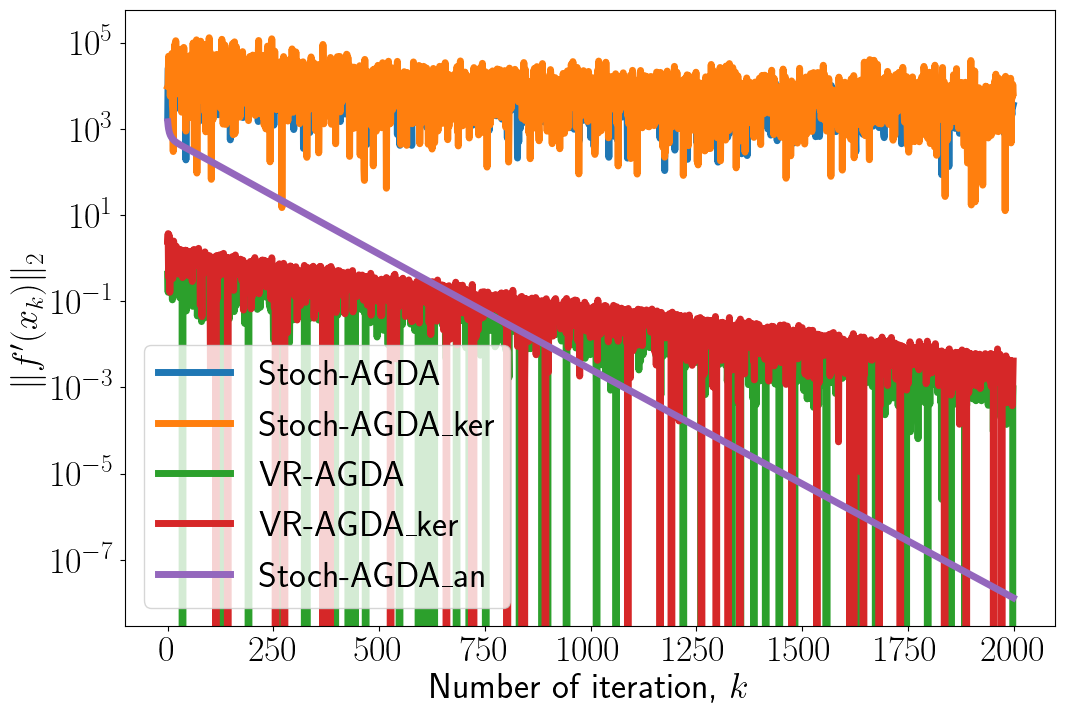

In [351]:
%matplotlib inline
import matplotlib.pyplot as plt

USE_COLAB = False
if not USE_COLAB:
    plt.rc("text", usetex=True)

plt.figure(figsize=(12,8))
plt.semilogy(np.arange(len(resi)), resi, 
             label=r"Stoch-AGDA", linewidth=5)
plt.semilogy(np.arange(len(resi2)), resi2, 
             label=r"Stoch-AGDA_ker", linewidth=5)
plt.semilogy(np.arange(len(resi3)), resi3, 
             label=r"VR-AGDA", linewidth=5)
plt.semilogy(np.arange(len(resi4)), resi4, 
             label=r"VR-AGDA_ker", linewidth=5)
plt.semilogy(np.arange(len(resi5)), resi5, 
             label=r"Stoch-AGDA_an", linewidth=5)
plt.legend(loc="best", fontsize=26)
plt.xlabel("Number of iteration, $k$", fontsize=26)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=26)
plt.xticks(fontsize=26)
_ = plt.yticks(fontsize=26)

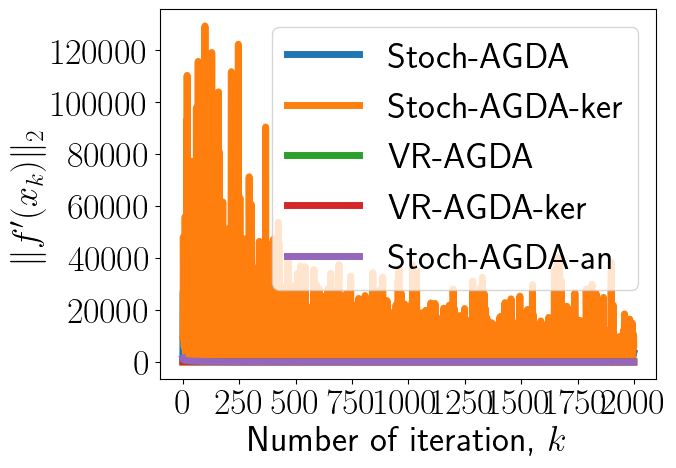

In [352]:
plt.plot(resi, label=r"Stoch-AGDA", linewidth=5)
plt.plot(resi2, label=r"Stoch-AGDA-ker", linewidth=5)
plt.plot(resi3, label=r"VR-AGDA", linewidth=5)
plt.plot(resi4, label=r"VR-AGDA-ker", linewidth=5)
plt.plot(resi5, label=r"Stoch-AGDA-an", linewidth=5)
plt.legend(loc="best", fontsize=26)
plt.xlabel("Number of iteration, $k$", fontsize=26)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=26)
plt.xticks(fontsize=26)
_ = plt.yticks(fontsize=26)

In [353]:
print(np.linalg.norm(x3 - x_opt), np.linalg.norm(y3 - y_0))
print(np.linalg.norm(x4 - x_opt), np.linalg.norm(y4 - y_0))
print(np.linalg.norm(x5 - x_opt), np.linalg.norm(y5 - y_0))
print(F(x_opt, y_0) - F(x5, y5))

9.847105796983916 0.17137842414383606
11.244114351100034 0.2362277992739838
10.186637759916682 1.884965247361847e-09
0.005549280749413078


In [ ]:
def g(x, y):
    return np.linalg.norm(x-y)**2 - 3*np.linalg.norm(y)**2
def gx(x, y, *args):
    return 2*(x-y)
def gy(x, y, *args):
    return 2*(y-x)-6*y

In [ ]:
g( np.ones(1000),  3*np.ones(1000))

In [ ]:
x, y, resi = Stoc_AGDA(g,gradx, grady, np.ones(10), np.ones(10))
x2, y2, resi2 = Stoc_AGDA(g, gx,  gy, np.ones(1000), np.ones(1000))
# x3, y3, resi3 = VR_AGDA(g, gradx,  grady, grad_fx, grad_fy, np.ones(10), np.ones(10))
# x4, y4, resi4 = VR_AGDA(g, gradx_Kernel,  grady_Kernel, grad_fx_Kernel, grad_fy_Kernel, np.ones(10), np.ones(10))

In [ ]:
plt.figure(figsize=(12,8))
plt.semilogy(np.arange(len(resi)), resi, 
             label=r"Stoch-AGDA", linewidth=5)
plt.semilogy(np.arange(len(resi2)), resi2, 
             label=r"Stoch-AGDA_an", linewidth=5)
# plt.semilogy(np.arange(len(resi3)), resi3, 
#              label=r"VR-AGDA", linewidth=5)
# plt.semilogy(np.arange(len(resi4)), resi4, 
#              label=r"VR-AGDA_ker", linewidth=5)
plt.legend(loc="best", fontsize=26)
plt.xlabel("Number of iteration, $k$", fontsize=26)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=26)
plt.xticks(fontsize=26)
_ = plt.yticks(fontsize=26)